<a href="https://colab.research.google.com/github/esterfb3397/fake-news-project-tfm/blob/main/preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Para acceder al repositorio actualizado desde otro Notebook

!git clone https://github.com/esterfb3397/fake-news-project-tfm.git


Cloning into 'fake-news-project-tfm'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 35 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), 1.86 MiB | 5.25 MiB/s, done.


#Librerias

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 

 
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


<ipython-input-2-d5b16a8e92e7>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
random_state = 1

In [6]:
#df = pd.read_excel('/content/clean_data.xlsx')
df = pd.read_pickle('/content/df.pickle')

In [7]:
df.head(2)

label                                         title_text  length  nwords  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702     761   
1      0  U.S. military to accept transgender recruits o...    4120     632   

   avg_char_word  n_distint_word  
0       6.178712             424  
1       6.518987             338

Vemos que se ha cargado bastante bien, de momento vamos a eliminar las columnas subject,nwords,avg_char_word y n_distint_word

In [8]:
df = df.drop([ 'nwords','avg_char_word','n_distint_word'], axis=1)

In [9]:
df.head(2)

label                                         title_text  length
0      0  As U.S. budget fight looms, Republicans flip t...    4702
1      0  U.S. military to accept transgender recruits o...    4120

# Transformación

## Normalización
Vamos a proceder a normalizar los datos. Para ello vamos a generar pequeñas funciones que nos permitan:

- Transformar a minúsculas.


- Lematizar tokens.
- Tokenizar.
- Eliminar stopwords.
- Eliminar sígnos de puntuación.

In [10]:
#nos importamos un df limpio por si acaso
df = df.copy()

#### Eliminamos espacios

In [11]:
def eliminar_espacios(text): 
    return  " ".join(text.split())
df['espacios'] = df['title_text'].apply(eliminar_espacios)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...

#### Minusculas


In [12]:
# To lower
def texto_to_lower(text):
  return text.lower()
df['minusculas'] = df['espacios'].apply(texto_to_lower)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

#### Quitamos posibles emojis


In [13]:
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2
df['emojis'] = df['minusculas'].apply(clean_emoji)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

Quitamos html

In [14]:
from bs4 import BeautifulSoup

In [15]:
def strip_html(text):
  soup = BeautifulSoup(text,"html.parser")
  return soup.get_text()
df['html'] = df['emojis'].apply(strip_html)
df.head(2)


label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

ELiminar cosas entre parentesis

In [16]:
def remove_between_square_brackets(text):
  return re.sub('/[[^]]*\]','',text)
df['parentesis'] = df['html'].apply(strip_html)
df.tail(2)

label                                         title_text  length  \
22701      1  Federal Showdown Looms in Oregon After BLM Abu...   20747   
22702      1  A Troubled King: Chicago’s Rahm Emanuel Desper...    5833   

                                                espacios  \
22701  Federal Showdown Looms in Oregon After BLM Abu...   
22702  A Troubled King: Chicago’s Rahm Emanuel Desper...   

                                              minusculas  \
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                  emojis  \
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                    html  \
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                              parentesis  
22701  federal showdown looms in oregon after blm abu...  
22702  a troubled king: chicago’s rahm emanuel desper...

#### ELiminar URL

In [17]:
def url(text):
  return re.sub(r'http/S+','',text)
df['url'] = df['parentesis'].apply(strip_html)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

Esto se va a eliminar mas tarde vamos a crear un length nuevo para ver como va el preprocesado

In [18]:
df['length_2'] = df['url'].apply(lambda x: len(x))


Tokenizador

In [19]:
import nltk

In [20]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# Tokenizador
from nltk import word_tokenize

def tokenization(text):
  tokens = word_tokenize(text)
  return tokens

In [22]:
df['tokenizado'] = df['url'].apply(tokenization)

In [24]:
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  
0  [as, u.s., budget, fight, looms, ,, republican...  
1  [u.s., military, to, accept, transgender, recr...

Quitar stopwords

In [23]:
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence

In [24]:
df['stopwords'] = df['tokenizado'].apply(quitar_stopwords)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  
0  [u.s., budget, fight, looms, ,, republicans, f...  
1  [u.s., military, accept, transgender, recruits...

Quitar puntuacion

In [25]:
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words
df['puntuacion'] = df['stopwords'].apply(quitar_puntuacion)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  \
0  [u.s., budget, fight, looms, ,, republicans, f...   
1  [u.s., military, accept, transgender, recruits...   

                                          puntuacion  
0  [budget, fight, looms, republicans, flip, fisc...  
1  [military, accept, transgender, recruits, mond...

#### Steamming

In [26]:
import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens


In [27]:
df['steam'] = df['puntuacion'].apply(stem)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  \
0  [u.s., budget, fight, looms, ,, republicans, f...   
1  [u.s., military, accept, transgender, recruits...   

                                          puntuacion  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   

                                               steam  
0  [budget, fight, loom, republican, flip, fiscal...  
1  [militari, accept, transgend, recruit, monday,...

se ha hecho el preprocesado, y antes de introducirlo a TFIDF vamos a generar una frase de gada una de las listas de tokens, para utilizar el propio tokenizador de TFIDF

In [28]:
df["clean_text"] = df["steam"].apply(lambda x: " ".join(x))

In [29]:
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  \
0  [u.s., budget, fight, looms, ,, republicans, f...   
1  [u.s., military, accept, transgender, recruits...   

                                          puntuacion  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   

                                               steam  \
0  [budget, fight, loom, republican, flip, fiscal...   
1  [militari, accept, transgend, recruit, monday,...   

                                          clean_text  
0  budget fight loom republican flip fiscal scrip...  
1  militari accept transgend recruit monday penta...

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


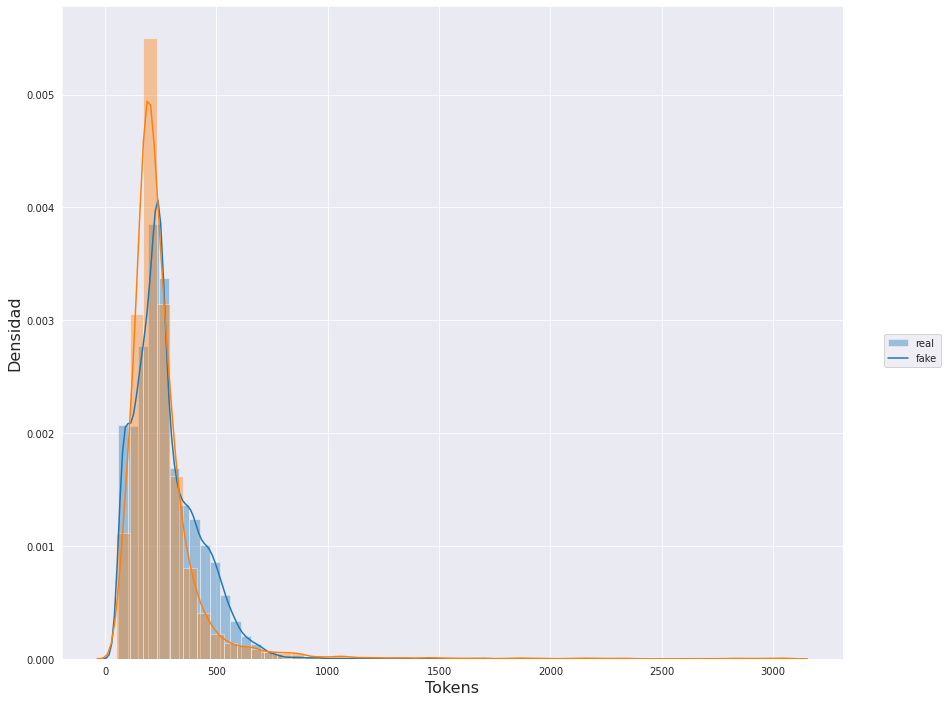

In [30]:
df["token_len"] = df['steam'].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
plt1 = sns.distplot(df[df.label==0].token_len, hist=True, label="real")
plt2 = sns.distplot(df[df.label==1].token_len, hist=True, label="fake")
fig.legend(labels=['real','fake'],loc=5)

# Definimos el título de los ejes:
plt.xlabel('Tokens', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

En el gráfico podemos comprobar que las noticias reales agrupan una cantidad de tokens entre 0 y 700 y tienen una menor cantida de densidad en comparacion con las noticas falsas queconcentran mas densidad de palabras

In [31]:
df['clean_text'] = df['clean_text'].str.replace("'","")

In [32]:
df['clean_text']

0        budget fight loom republican flip fiscal scrip...
1        militari accept transgend recruit monday penta...
2        senior republican senat mueller job special co...
3        fbi russia probe help australian diplomat nyt ...
4        trump want postal servic charg amazon shipment...
                               ...                        
22698    white hous theatric gun control 21st centuri w...
22699    activist terrorist media control dictat narr b...
22700    boiler room surrend retreat head roll ep 38 tu...
22701    feder showdown loom oregon blm abus local ranc...
22702    troubl king chicago rahm emanuel desper save 2...
Name: clean_text, Length: 28961, dtype: object

In [33]:
from wordcloud import WordCloud

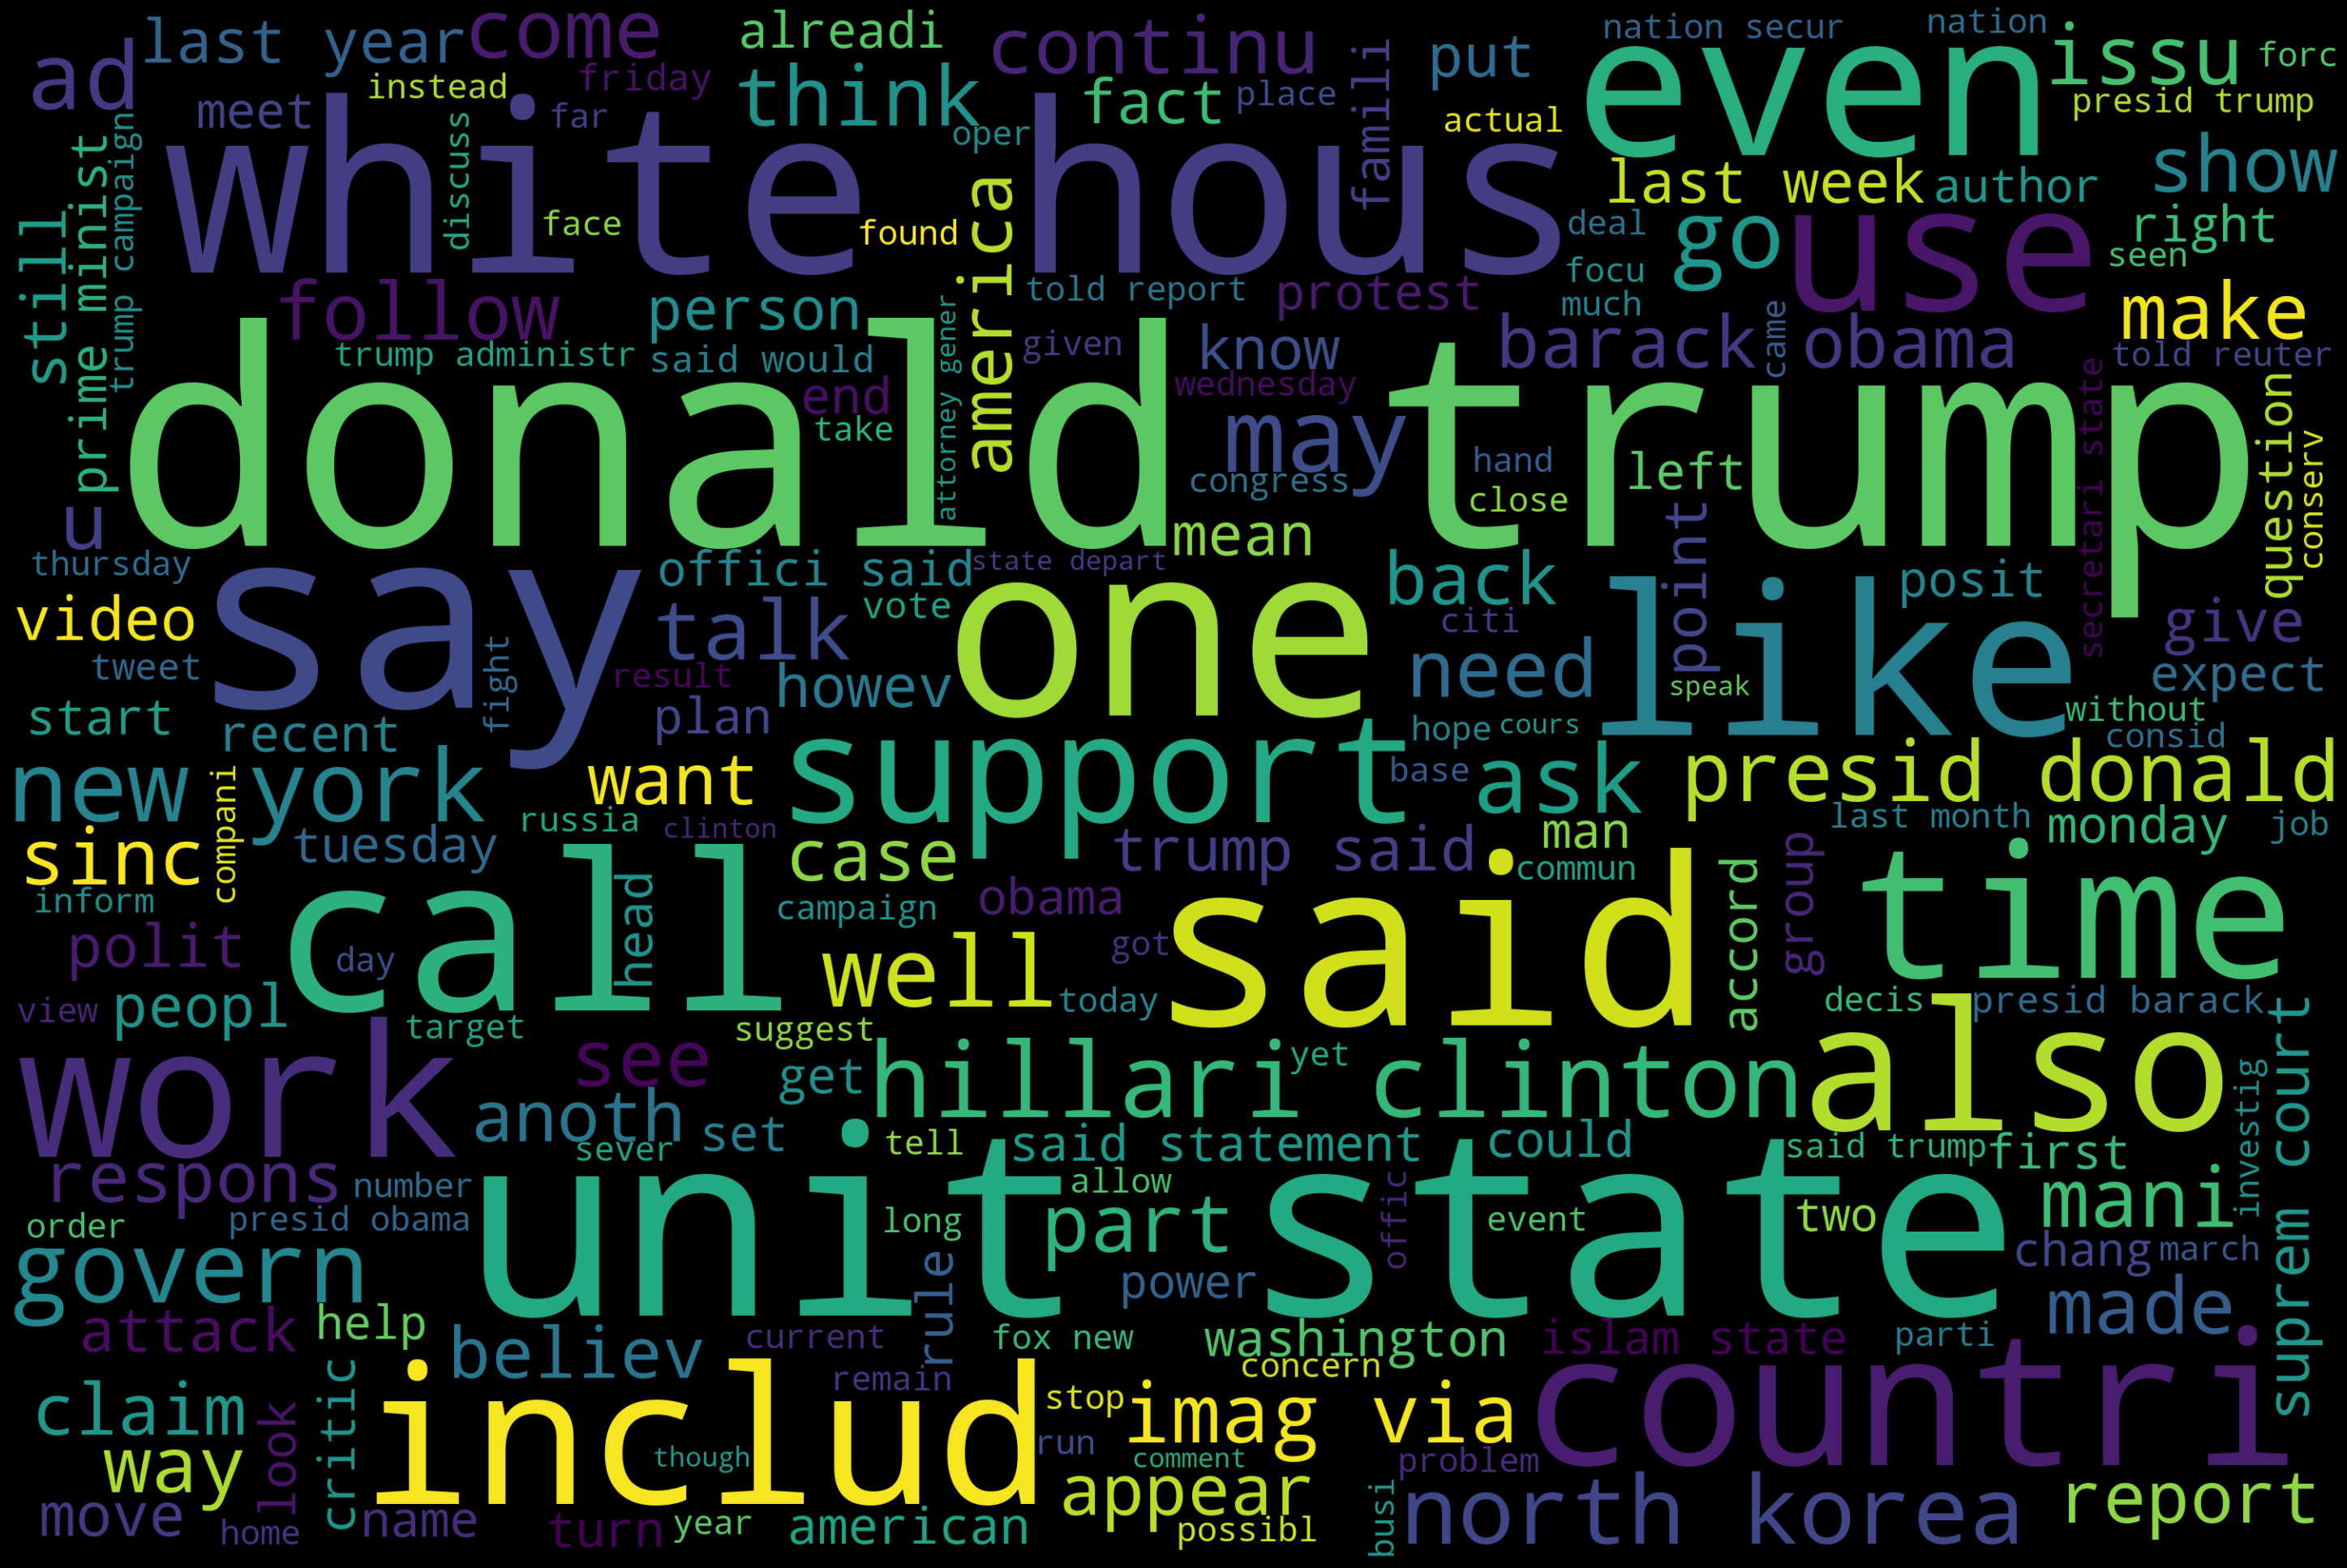

In [34]:
#Word Cloud
text = ''
for news in df.clean_text:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text


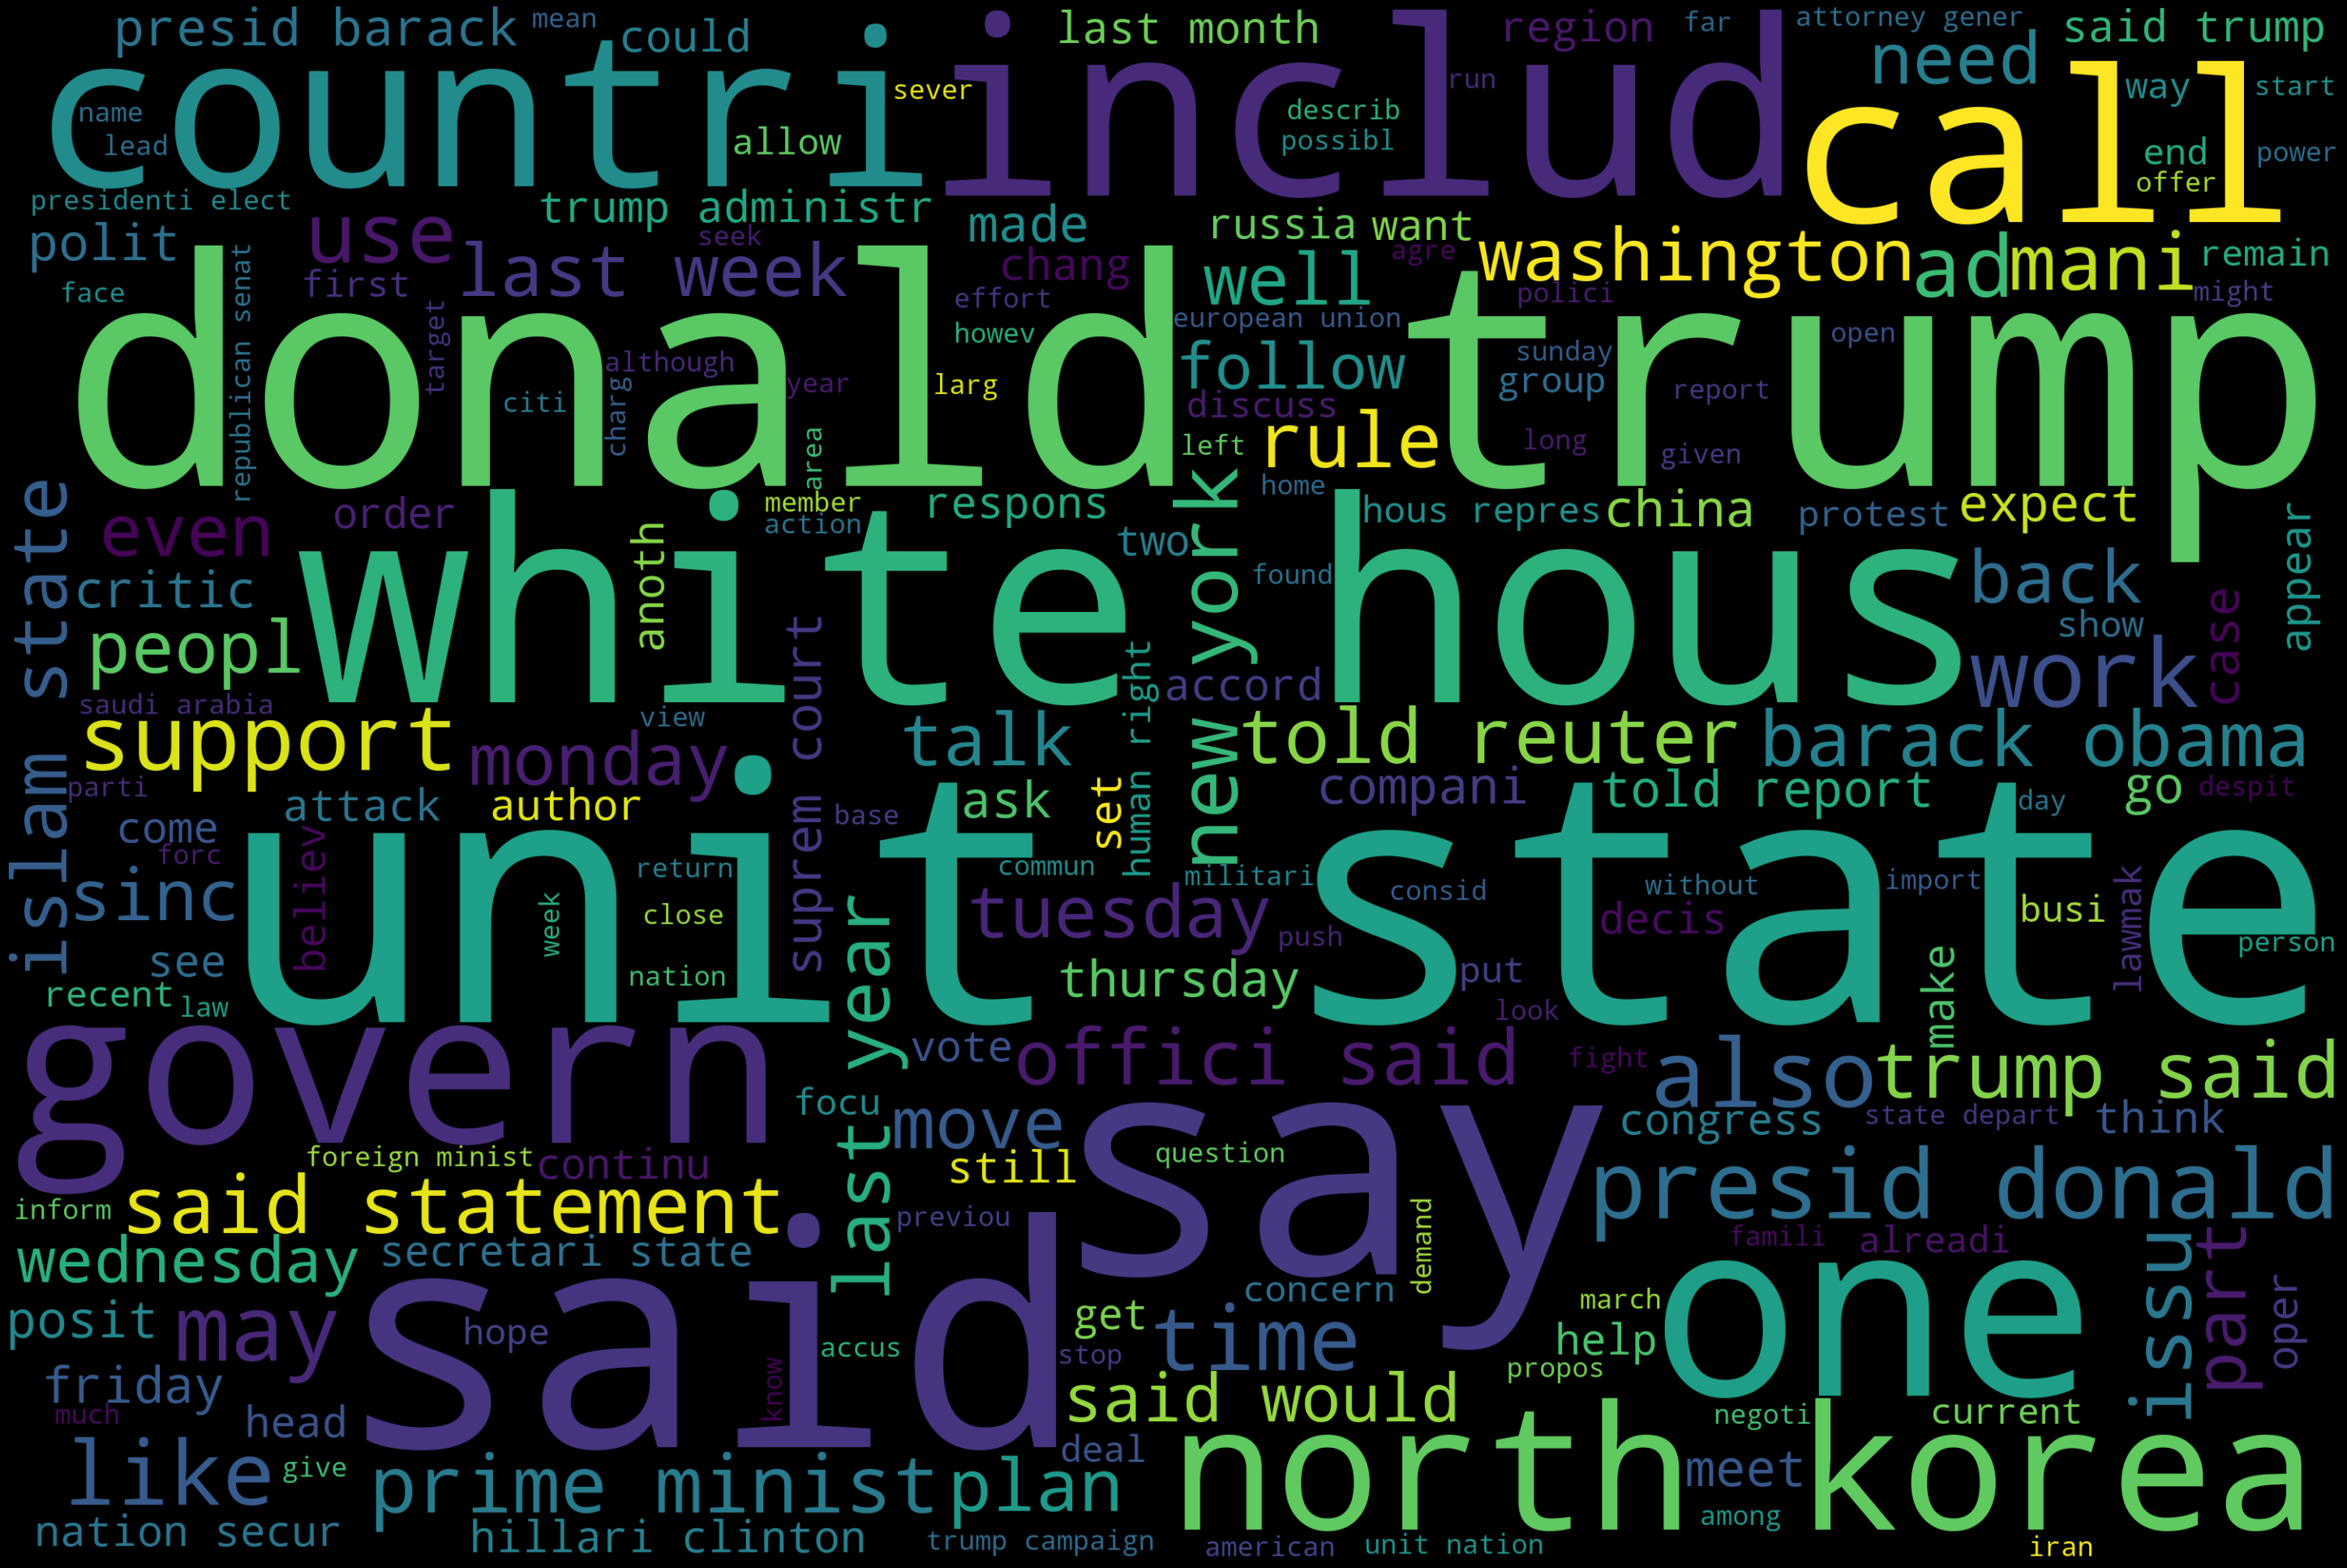

In [35]:
text = ''
for news in df[df.label==0].clean_text:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text


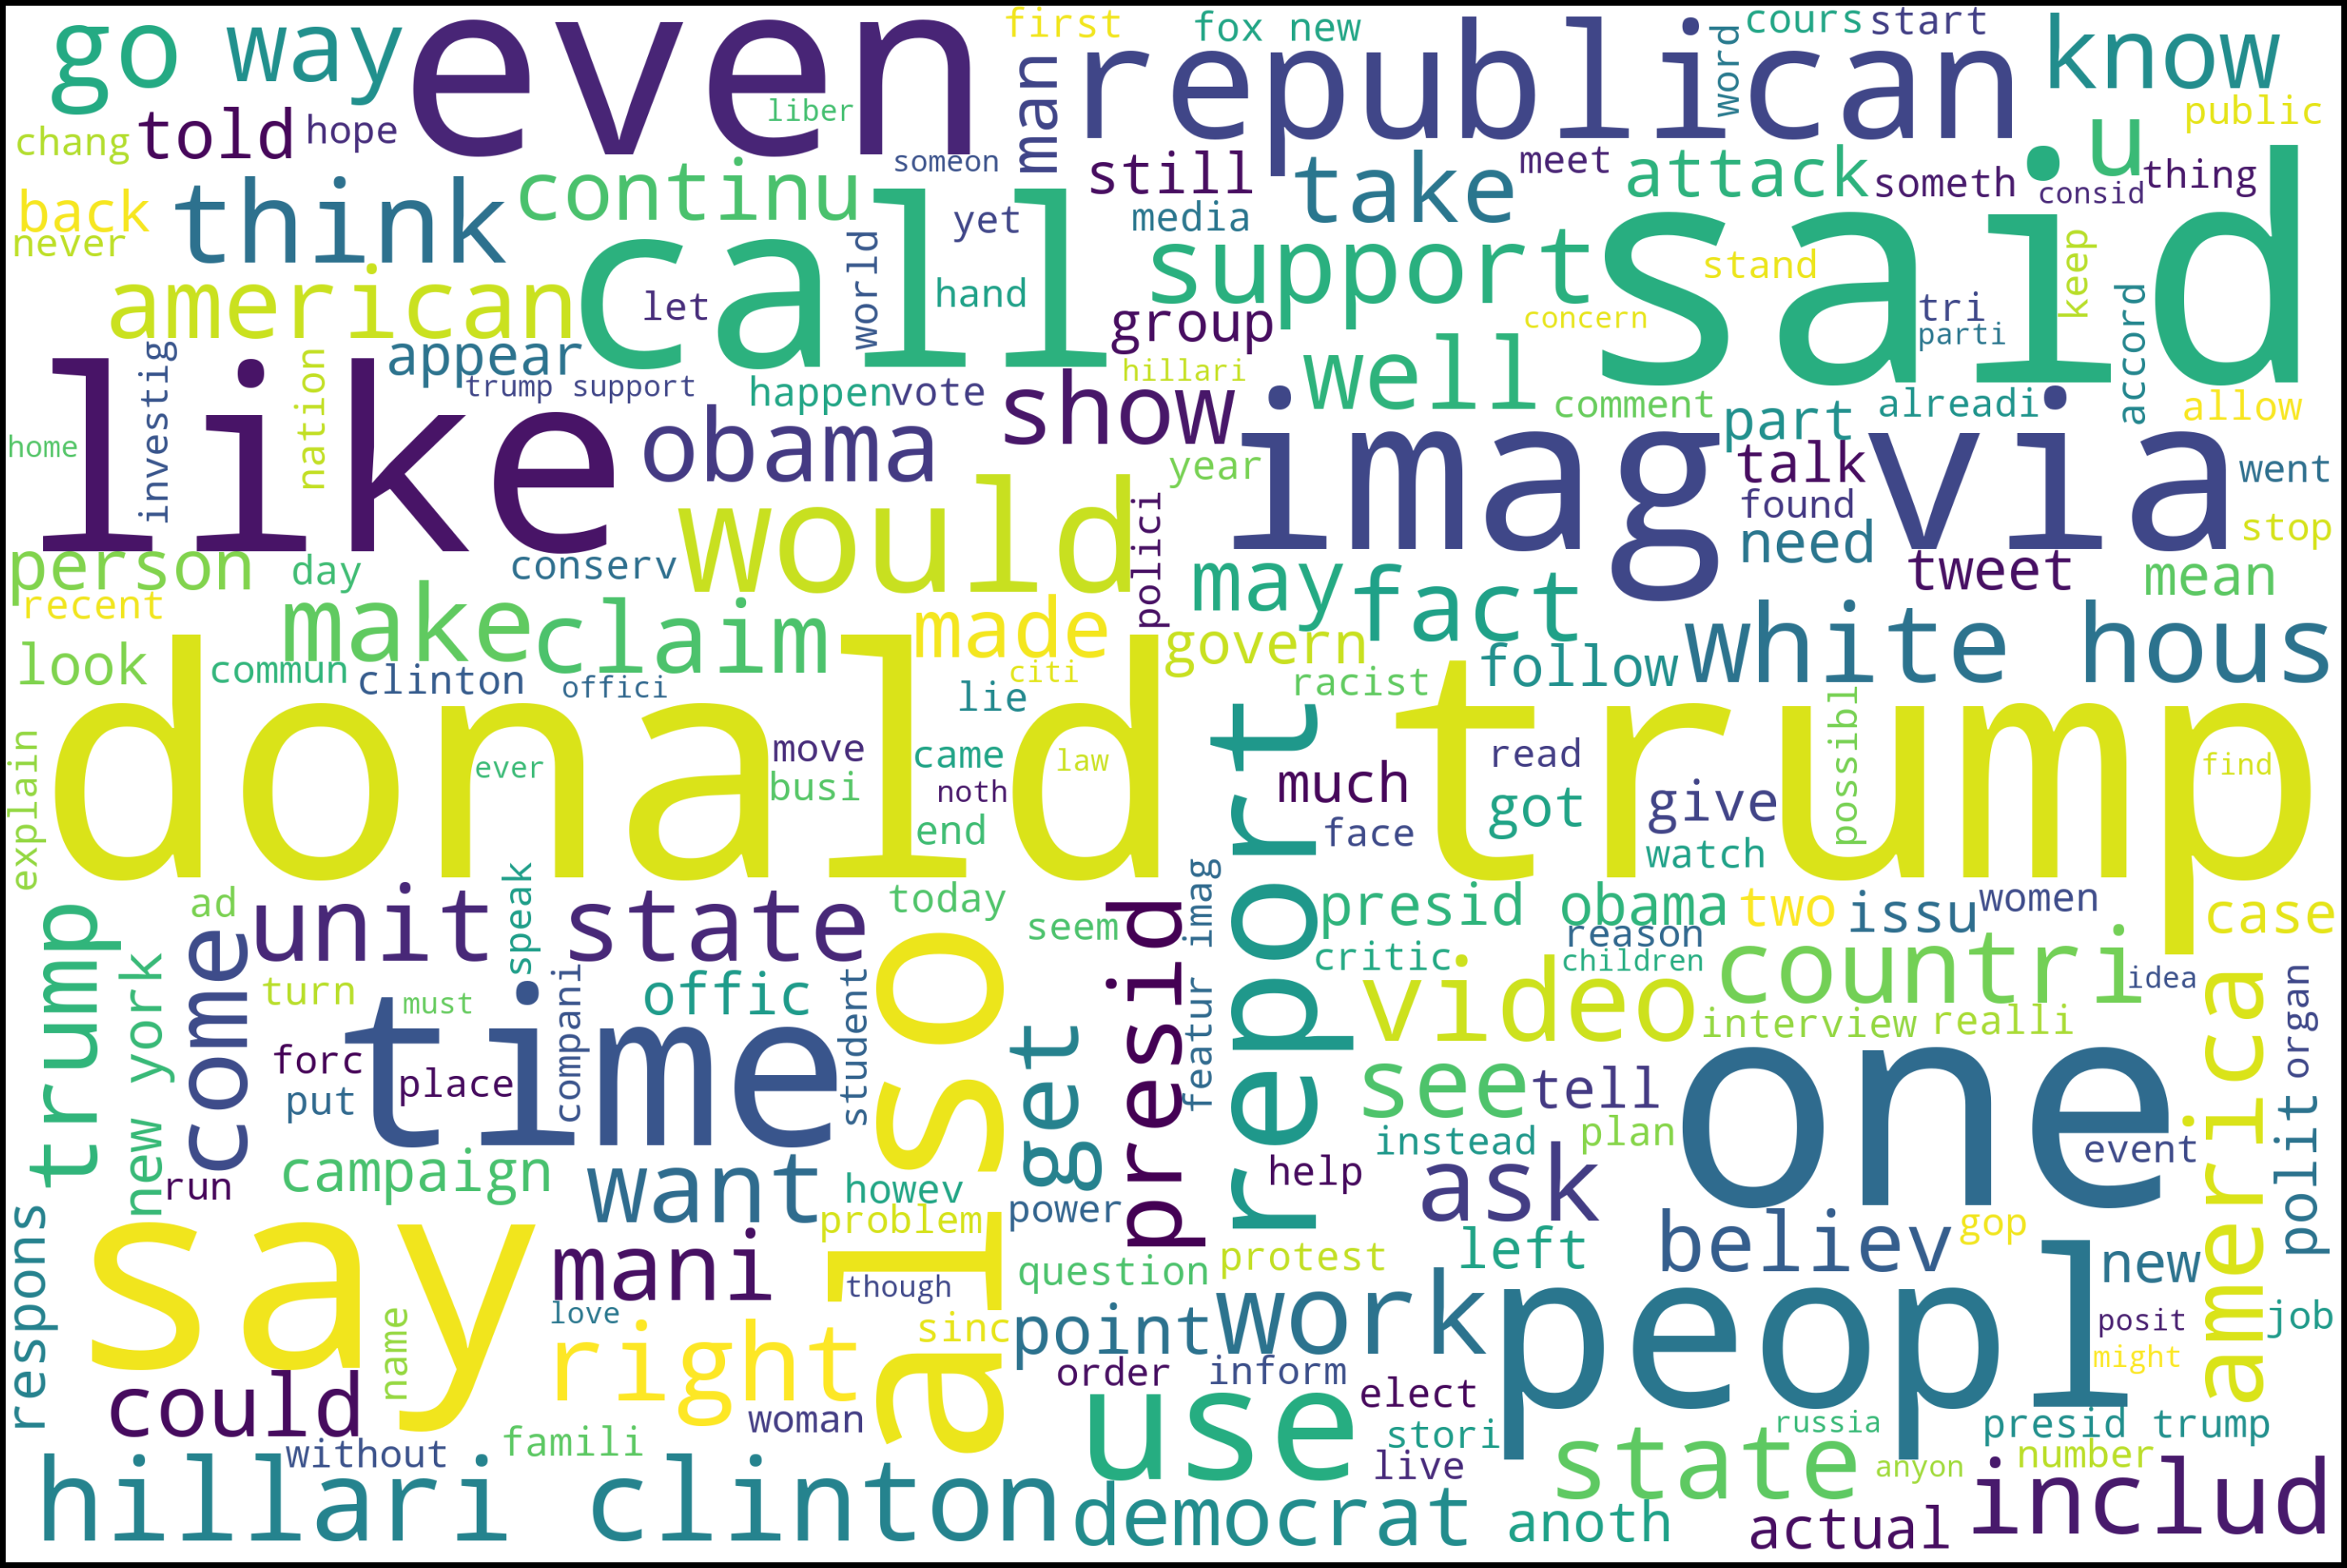

In [36]:
text = ''
for news in df[df.label==1].clean_text:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

## Vectorizacion

In [37]:
vectorizador = TfidfVectorizer(max_features=30,ngram_range= (1,3) ,min_df = 0.01,lowercase = False)

vector_data = vectorizador.fit_transform(df['clean_text'])

In [38]:
vector_data

<28961x30 sparse matrix of type '<class 'numpy.float64'>'
	with 361270 stored elements in Compressed Sparse Row format>

## Entrenamiento y evaluación de modelos


El primer paso es definir las variables predictoras, que son las características extraidas anteriormente a través de TF-IDF. 

También especificaremos cual es la variable con las clases de cada documento.


In [39]:
# Importamos numpy:
import numpy as np

# Definimos la variable de categorías:
y = df["label"].values.astype(np.float32) 

print(y.shape)

(28961,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(vector_data, y , random_state=random_state)
print(X_train.shape)
print(X_test.shape)

(21720, 30)
(7241, 30)


**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados. 

La función hace un KFold y evalua diferentes modelos con una métrica de evaluación:

In [41]:
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 

In [42]:
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = random_state)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [43]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.linear_model import SDGClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier



# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state = 30)), # Logistic ¡Regression
         ("GaussianNB",GaussianNB()),
         ("LinearSVC",LinearSVC()),
         ("LinearDiscriminantAnalysis",LinearDiscriminantAnalysis()),

          ("DecisionTreeClassifier",DecisionTreeClassifier()),
          ("GradientBoostingClassifier",GradientBoostingClassifier()),
          ("RandomForestClassifier",RandomForestClassifier())]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, vector_data.toarray(), y)   

Metric: accuracy , KFold 
Logistic: 0.856462 (0.005496) 
Metric: accuracy , KFold 
GaussianNB: 0.792479 (0.005124) 
Metric: accuracy , KFold 
LinearSVC: 0.856359 (0.005842) 
Metric: accuracy , KFold 
LinearDiscriminantAnalysis: 0.853631 (0.006582) 
Metric: accuracy , KFold 
DecisionTreeClassifier: 0.811505 (0.005806) 
Metric: accuracy , KFold 
GradientBoostingClassifier: 0.882221 (0.005057) 
Metric: accuracy , KFold 
RandomForestClassifier: 0.886330 (0.006013) 


([array([0.85329651, 0.85808011, 0.85220994, 0.85497238, 0.8663674 ,
         0.86049724, 0.85635359, 0.8566989 , 0.84495856, 0.86118785]),
  array([0.79910252, 0.79316298, 0.79316298, 0.78073204, 0.79799724,
         0.79558011, 0.79212707, 0.79558011, 0.78798343, 0.78936464]),
  array([0.85260614, 0.85946133, 0.85290055, 0.85393646, 0.86671271,
         0.86015193, 0.85600829, 0.8566989 , 0.84392265, 0.86118785]),
  array([0.85191577, 0.85773481, 0.84599448, 0.84703039, 0.86325967,
         0.85635359, 0.85773481, 0.85428177, 0.84150552, 0.86049724]),
  array([0.81152917, 0.81146409, 0.81457182, 0.80870166, 0.81733425,
         0.81906077, 0.81906077, 0.80801105, 0.80145028, 0.8038674 ]),
  array([0.87953055, 0.88535912, 0.88156077, 0.88225138, 0.88812155,
         0.88984807, 0.88570442, 0.87948895, 0.87154696, 0.87879834]),
  array([0.89057646, 0.89088398, 0.88604972, 0.88190608, 0.89537293,
         0.89088398, 0.88846685, 0.88535912, 0.87396409, 0.87983425])],
 ['Logistic',
  'Ga

#### Modelo 1

Observamos un mejor funcionamiento con RandomForestClassifier, que será con el que intentaremos afinar los hiperparámetros:

Vamos a generar un diccionario para la búsqueda Grid y también generaremos el objeto GridSearchCV. Vamos a utilizar una métrica de búsqueda basada en accuracy (por probar)

In [45]:
df["label"] = df["label"].astype(str)

In [58]:
model1 = GridSearchCV(
    estimator=Pipeline(
        steps = [
            ("TfidfVectorizer", TfidfVectorizer(
                lowercase = False
            )),
            ("LogisticRegression", LogisticRegression(
                penalty = "l2",
                random_state = random_state
            ))
        ]
    ),
    param_grid = {
        "TfidfVectorizer__lowercase": [True, False],
        "TfidfVectorizer__max_features": [30, 50, 75],
        "TfidfVectorizer__ngram_range": [(1,1), (1,2), (1,3)],
        "LogisticRegression__C": [1e-3, 1e-4, 1e-5]
    },
    n_jobs = -1,
    cv = 5,
    verbose = 3
)

In [69]:
df_copy = df.sample(frac=1).head(1000)
X_train, X_test, y_train, y_test = train_test_split(df_copy["clean_text"], df_copy["label"], random_state = random_state)
print(X_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(750,)
(250,)
0    417
1    333
Name: label, dtype: int64
1    125
0    125
Name: label, dtype: int64


In [70]:
model1.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer',
                                        TfidfVectorizer(lowercase=False)),
                                       ('LogisticRegression',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'LogisticRegression__C': [0.001, 0.0001, 1e-05],
                         'TfidfVectorizer__lowercase': [True, False],
                         'TfidfVectorizer__max_features': [30, 50, 75],
                         'TfidfVectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             verbose=3)

In [61]:
model1.best_estimator_.named_steps["LogisticRegression"].coef_

array([[-6.90177931e-04,  2.25935701e-04,  2.09301361e-03,
        -3.21450108e-03,  1.12578314e-04,  2.70892341e-03,
        -8.09301355e-04, -3.03506982e-03, -2.31951159e-03,
         4.17322499e-03,  2.72992421e-03, -1.58496976e-03,
        -4.57283996e-04,  6.45657478e-04,  3.50624414e-03,
        -1.95972718e-03,  4.40084088e-03, -5.96976544e-04,
        -1.24471936e-05, -1.30841259e-02,  1.13363892e-03,
        -4.38008903e-03, -4.27528207e-03,  2.81695160e-04,
         6.50728465e-03, -3.48004654e-03,  1.65960878e-03,
        -9.26379484e-04, -1.17363879e-03, -1.18745131e-03]])

In [76]:
model1.best_estimator_

Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer(max_features=30)),
                ('LogisticRegression',
                 LogisticRegression(C=0.001, random_state=1))])

In [62]:
model1.best_estimator_.named_steps["LogisticRegression"].intercept_

array([0.24246221])

In [63]:
model1.best_params_

{'LogisticRegression__C': 0.001,
 'TfidfVectorizer__lowercase': True,
 'TfidfVectorizer__max_features': 30,
 'TfidfVectorizer__ngram_range': (1, 1)}

In [64]:
model1.fit(X_train, y_train)

# Get the best hyperparameters
best_params = model1.best_params_

# Create a new pipeline with the optimal hyperparameters
pipeline = Pipeline([
    ("TfidfVectorizer", TfidfVectorizer(
        lowercase = best_params["TfidfVectorizer__lowercase"],
        max_features = best_params["TfidfVectorizer__max_features"],
        ngram_range = best_params["TfidfVectorizer__ngram_range"]
    )),
    ("LogisticRegression", LogisticRegression(
        penalty = "l2",
        C = best_params["LogisticRegression__C"],
        random_state = random_state
    ))
])

# Fit the new pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = pipeline.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy: {:.2f}%".format(accuracy * 100))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Accuracy: 42.67%


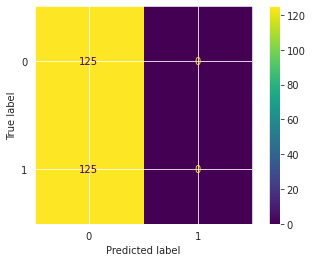

In [77]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_test, y_test, normalize = None)

In [71]:
model1.score(X_train, y_train)

0.556

In [72]:
model1.score(X_test, y_test)

0.5

In [74]:
from sklearn.metrics import classification_report
target_names = df["label"].unique()
print(classification_report(
    y_true = y_test, 
    y_pred = model1.predict(X_test), 
    target_names=target_names
))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       125
           1       0.00      0.00      0.00       125

    accuracy                           0.50       250
   macro avg       0.25      0.50      0.33       250
weighted avg       0.25      0.50      0.33       250



#### Modelo 2

In [ ]:
model2 = GridSearchCV(
    estimator=Pipeline(
        steps = [
            ("TfidfVectorizer", TfidfVectorizer(
                lowercase = False
            )),
            ("RandomForest", RandomForestClassifier(
                penalty = "l2",
                random_state = random_state,
                class_weight{
            ))
        ]
    ),
    param_grid = {
        criterion{“gini”, “entropy”, “log_loss”}
        "TfidfVectorizer__lowercase": [True, False],
        "TfidfVectorizer__max_features": [30, 50, 75],
        "TfidfVectorizer__ngram_range": [(1,1), (1,2), (1,3)],
        "LogisticRegression__C": [1e-3, 1e-4, 1e-5]
    },
    n_jobs = -1,
    cv = 5,
    verbose = 3
)

In [ ]:
model2 = RandomForestClassifier()

In [ ]:
param_grid = {
    'max_depth': [2,4],
    'criterion' :['gini', 'entropy','log_loss']
}
# initialize
grid_pipeline = GridSearchCV(estimator=model2,param_grid = param_grid,n_jobs=-1, verbose=1, cv=3, scoring='f1')
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

In [ ]:
print("Mejor accuracy: %f usando los parámetros %s" % (grid_pipeline.best_score_, grid_pipeline.best_params_))

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Aunque en un primer modelo RandomForestClassifier ha arrojado mayor accuracy, al entrenar el modelo ganaria el modelo 1 

In [ ]:
model2=RandomForestClassifier(criterion = 'gini',max_depth=4)
model2.fit(X_train,y_train)

In [ ]:
y_pred = model2.predict(X_test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model2, X_test, y_test, normalize = None)

#### Modelo 3

Este modelo será el del modelo 1 pero aplicado a redes neuronales

In [ ]:
GradientBoostingClassifier

#### Modelo 4

In [ ]:
LinearSVC: